# Data curation using data from WardWatcher (ICNARC) and Philips (ICCA).

## Contents:
### [1. Data Linkage](#section1)

We show how data extracted from the ICNARC database (via the Ward Wacther software) is linked to the Philips data to provide more information on patient outcomes, medical history and diagnoses. These ICNARC data, curated as demonstrated here, are included in our research database as a new table: *D_Icnarc* (following the table naming convention for the Philips data), which links to other database tables on *encounterId* and *ptcensusId*.  

### [2. Demonstration analysis.](#section2)

We demonstrate some basic analysis of common interventions extracted from the research database. This is for illustrative purposes to show potential users what kind of data is available.

***
This script uses the following data files:
* *encounter_summary.rpt* - a tab separated file with output from an SQL query run on ICCA to extract basic information about patient encounters (ITU stays).

* *ICNARC 2015-2018 encounterIds and Readmissions.TXT* - a file containing ICNARC patient IDs and the corresponding *CIS Patient ID*, which link to the *encounterId* numbers in ICCA.

* *Philips encounterId Issue List (New).xlsx* - a file documenting known issues with either *encounterIds* in Philips or *CIS Patient IDs* in WW. We clean up the IDs using this file before joining the two datasets.

* *ICNARC_Dataset_2015-2018_clean_.xml* - xml file containing standard format output of ICNARC CMP dataset.

* *ICNARC CMP Dataset Properties.xlsx* - description of the variables in the ICNARC dataset.

***

In [ ]:
VERBOSE = False ## For reasons of data protection we supress printing of results and data summaries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<a id='section1'></a>

***
### 1. Data Linkage.

#### Functions for cleaning up the encounter IDs and parsing the ICNARC xml file are imported: 

In [3]:
from clean_encounterids import *
from parse_ICNARC_xml import *

#### Clean up ICNARC CIS ID numbers.

Each record in the ICNARC data links to an encounterId in Philips. In some few cases the links are wrong (e.g. it links to an empty record). The following function fixes those encounter IDs in the ICNARC data by replacing the erroneous encounterIds in the column *CIS Patient ID*. It also creates a new column *CIS Patient ID Original* which contains the original encounterIds prior to replacement. At the time of writing there are only 5 such errors for GICU. These errors are logged by the ICNARC database team at UHB.

In [4]:
icnarc_numbers = clean_icnarc_cis_ids('../ICNARC 2015-2018 encounterIds and Readmissions.TXT', 
                                      '../Philips encounterId Issue List (New).xlsx',
                                    verbose=VERBOSE)

#### Clean up Philips encounterId numbers.

The Philips database creates a new encounterId for each intensive care stay. Sometimes this process doesn't work as desired e.g. erroneous records are created, patients are accidentally discharged and readmitted creating a new record etc. 

The following function fixes the class of errors that results in duplicate encounterIds which correspond to the same physical intensive care stay. It does so by replacing the erroneous encounterIds with the 'main' encounterId for that stay (i.e. the encounterId that links to the corresponding ICNARC record). It also creates a new column, *encounterId_original*, that contains the original ids prior to replacement. In the research database all instances of the erroneous IDs are replaced such that duplicate records are remapped. To the original ICCA table *D_Encounter* we add the *encounterId_original* column, and the *error_type* column described below.

When the flag *log_error_type* is set to True, the function creates another new column *error_type* which specifies the type of error associated with each encounterId. It gives a string containing one of 16 error types identified by Josh Inoue (UHB) and described in the file "Philips encounterId Read Me.txt", or contains "NA" if there is no known error. This flag is useful because there are encounterIds which we know have an issue but which we do not alter. For example, very occasionally a patient is discharged from ICU and then readmitted but is never removed from the Philips system. In such cases we know that a single encounterId in Philips (and in ICNARC) corresponds to two physical ICU stays. With the *error_type* flag, the user of the data can decide how they want to deal with different types of error during data processing.      

In [5]:
philips_data = clean_philips_encounterids('../encounter_summary (1).rpt', 
                                  '../Philips encounterId Issue List (New).xlsx',
                                  verbose=VERBOSE, log_error_type=True)

Because we have replaced some erroneous encounterIds with their correct value, there are now multiple rows with the same *encounterId*, with each containing a fragement of data relating to a whole intensive care stay. We combine the stay fragements (and the data they contain) so that each row corresponds to a single stay. This is consistent with the desired behaviour of the *D_Encounter* table. 

Note: this combination of fragmented data means that the *D_Encounter* table in our research database is slghtly shorter than the original table. (The original table could be reconstructed using the *encounterId_original* column.

In [6]:
philips_data = combine_non_unique_philips_encounters(philips_data, combine='simple', verbose=VERBOSE)
if not philips_data['encounterId'].is_unique:
    print "Warning: non-unique ID."

#### Link ICNARC to Philips.

Having cleaned the encounterId numbers we can now have a one-to-one mapping between *Philips:encounterId* and *ICNARC:CIS Patient ID* and we can safely link ICNARC records to the corresponding ICU stays in Philips. The following function renames the *CIS Patient ID* column in the ICNARC data as *encounterId* and then does an sql-style inner join on the column using *pandas.DataFrame.merge*

In [7]:
icustays = join_icnarc_to_philips(philips_data, icnarc_numbers, verbose=VERBOSE)
icustays.columns

Index([u'encounterId', u'ptCensusId', u'outTime', u'lengthOfStay (mins)',
       u'tNumber', u'gender', u'age', u'error_type', u'inTime',
       u'encounterId_original', u'Unit ID', u'ICNARC number',
       u'CIS Patient ID Original', u'CIS Episode ID',
       u'Readmission during this hospital stay'],
      dtype='object')

#### This *icustays* table represents a clean link between ICNARC and Philips. 

#### Next we demonstrate the construction of the new database table *D_Icnarc* using data extracted from the local ICNARC dataset in standard XML format.

In [8]:
icnarc_data = parse_icnarc_xml("../ICNARC_Dataset_2015-2018__clean_.xml",
                               "../ICNARC CMP Dataset Properties.xlsx",
                              verbose=VERBOSE)

The ICNARC data links to 'icustays' on 'ICNARC number' and 'Unit ID'.

This join produces a wide table with 208 columns corresponding to each of the varibales in the ICNARC CMP. The *D_Icnarc* table in our research database is a subset of this table. (In the future ICNARC may start to collect time-stamped data to capture clinical trajectories, in which case we will need to add another table *PtIcnarcData*). 

Note: *D_Icnarc* links to other tables on *encounterId* and *episodeId* and it is possible that two ICNARC entries share the same encounterId for different episdoes when looking across different intensive care units in UHB. We are currently only discussing the general adult intensive care unit (GICU) so this is not an issue.

In [9]:
icnarc_data = icustays.merge(icnarc_data, on=['ICNARC number', 'Unit ID'])

#### Validation.

We now conduct some sanity checks and produce summary statistics on the data.

#### First we use variables from the initial WW/Philips join:

In [10]:
columns = [('Date of admission to your unit', 'Time of admission to your unit'), 
           ('Date of discharge from your unit', 'Time of discharge from your unit'),
           ('Date when fully ready to discharge', 'Time when fully ready to discharge'),
           ('Date of death', 'Time of death'),
           ('Date of declaration of brainstem death', 'Time of declaration of brainstem death'),
           ('Date body removed from your unit','Time body removed from your unit')]

icnarc_data = combine_date_time_columns(icnarc_data, columns, drop_originals=True)

In [11]:
icnarc_data['Date of Birth'] = pd.to_datetime(icnarc_data['Date of Birth'], infer_datetime_format=True)
icnarc_data['inTime'] = pd.to_datetime(icnarc_data['inTime'], infer_datetime_format=True)
icnarc_data['outTime']= pd.to_datetime(icnarc_data['outTime'], infer_datetime_format=True)
icnarc_data = calculate_icnarc_outtime(icnarc_data)

In [12]:
icnarc_data['icnarc_age'] = [(row['Datetime of admission to your unit'] - row['Date of Birth']).total_seconds()/(60*60*24*365.25) for i,row in icnarc_data.iterrows()]
icnarc_data['icnarc_los'] = [(row['icnarc_outTime'] - row['Datetime of admission to your unit']).total_seconds()/(60.0) for i,row in icnarc_data.iterrows()]

icnarc_data['icnarc_gender'] = icnarc_data['Sex'].apply(lambda x: 'Female' if x=='F' else 'Male')
icnarc_data['icnarc_bmi'] = icnarc_data['Weight in kg'].astype(float)/((icnarc_data['Height in cm'].astype(float)/100.0)**2)
icnarc_data = icnarc_data.drop(labels=['Sex'], axis=1)

#### and get the same summary data as printer above from philips ...

In [13]:
print_philips_summary(icnarc_data)

Age, median years (IQR): 64.0 (50.0, 73.0)
LOS, median days (IQR): 3.0 (1.7, 5.6)

Gender, % female: 39.7
(0.1 % of patients have no gender recorded in Philips.)
 


In [14]:
print_icnarc_summary(icnarc_data)

Age, median years (IQR): 64.2 (50.8, 73.4)
LOS, median days (IQR): 2.9 (1.7, 5.4)

Gender, % female: 39.6
(0.0 % of patients have no gender recorded in Philips.)
 
Readmission to ICU, #(%) : 147 (3.0)
(0.0 % of patients have no recording for this variable in WW.)


In [15]:
print "There are a total of %d ITU stays." %len(icnarc_data.encounterId.unique())

There are a total of 4831 ITU stays.


#### To calculate the in-hospital mortality status of each patient in the ICNARC data we need to combine the CMP variables DIS, HDIS, UDIS and UHDIS (see data flow diagram).

In [16]:
icnarc_data = calculate_icnarc_in_hospital_mortality(icnarc_data)

In [17]:
mortality = icnarc_data.groupby('icnarc_in_hospital_mortality').agg({'encounterId':'count'}).reset_index()
mortality = mortality.rename(columns={'encounterId':'count'})
mortality['rate'] = mortality['count'] / float(len(icnarc_data))
mortality

,icnarc_in_hospital_mortality,count,rate
0,A,3924,0.812254
1,D,905,0.187332
2,E,2,0.000414


In [18]:
primary_reasons = icnarc_data.groupby('Primary reason for admission to your unit').agg({'encounterId':'count'}).sort_values('encounterId', ascending=False).reset_index()
secondary_reasons = icnarc_data.groupby('Secondary reason for admission to your unit').agg({'encounterId':'count'}).sort_values('encounterId', ascending=False).reset_index()

In [19]:
icnarc_codes = {'1.1.4.39.1' : 'Primary lung tumour',
               '2.4.2.7.3' : 'Anoxic or ischaemic coma or encephalopathy',
               '1.3.9.39.1' : 'Pancreatic or pancreato-duodenal tumour',
               '2.1.10.7.3' : 'Anoxic or ischaemic coma or encephalopathy',
               '2.1.4.27.5' : 'Pneumonia, no organism isolated',
               '1.3.7.39.2' : 'Secondary hepatic tumour',
               '2.2.1.30.1' : 'Acute myocardial infarction',
               '1.3.2.39.1' : 'Malignant neoplasm of oesophagus',
               '1.3.6.39.2' : 'Malignant large bowel tumour',
               '2.1.4.27.1' : 'Bacterial pneumonia',
               '2.2.5.32.2' : 'Ventricular tachycardia or fibrilation',
               '2.2.12.35.2' : 'Septic shock, aetiology uncertain',
               '2.7.1.13.2' : 'Acute renal failure due to haemodynamic causes',
               '2.7.1.13.1' : 'Acute renal failure due to infection',
               '1.3.6.39.2' : 'Malignant large bowel tumour'}

#### Note: replace None with 'Other' below to count reasons outside of top 10 most frequent. 

In [20]:
primary_reasons['Primary reason'] = [icnarc_codes[code] if code in icnarc_codes.keys() else None for code in primary_reasons['Primary reason for admission to your unit']]
secondary_reasons['Secondary reason'] = [icnarc_codes[code] if code in icnarc_codes.keys() else None for code in secondary_reasons['Secondary reason for admission to your unit']]

In [21]:
primary_reasons = primary_reasons.groupby('Primary reason').agg({'encounterId':'sum'}).sort_values('encounterId', ascending=False).reset_index()
secondary_reasons = secondary_reasons.groupby('Secondary reason').agg({'encounterId':'sum'}).sort_values('encounterId', ascending=False).reset_index()

primary_reasons['percentage'] = 100*primary_reasons['encounterId']/float(len(icnarc_data))
secondary_reasons['percentage'] = 100*secondary_reasons['encounterId']/float(len(icnarc_data))

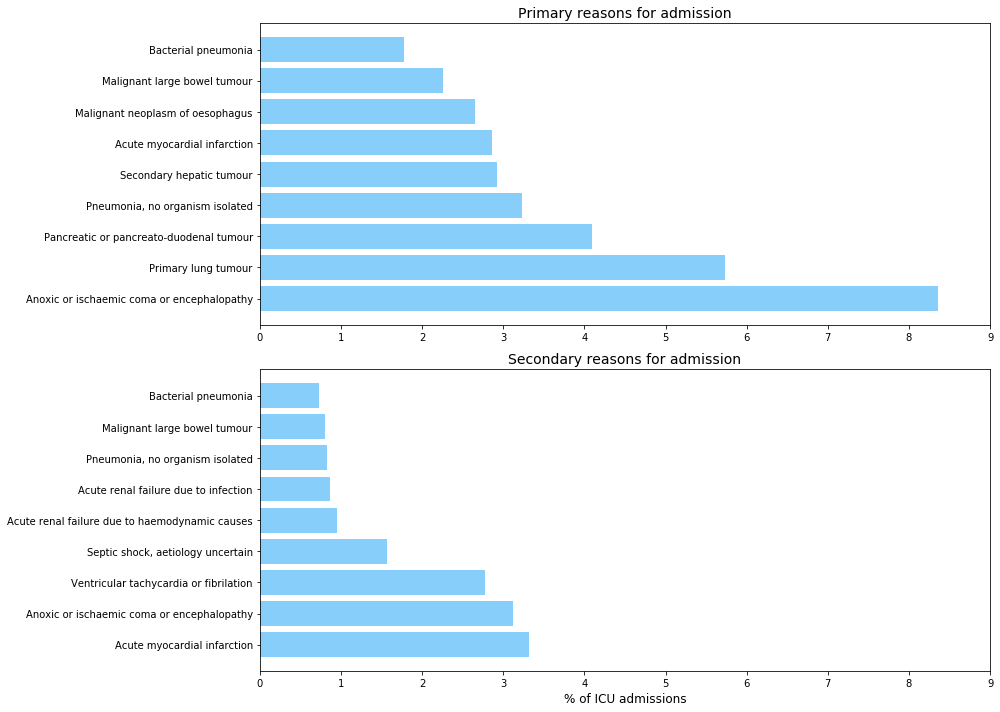

In [22]:
fig = plt.figure(figsize=(14,10))

reasons = primary_reasons.iloc[0:9]
ax = fig.add_subplot(211)
ax.barh(np.arange(len(reasons)),reasons['percentage'], tick_label=reasons['Primary reason'], color='lightskyblue');
ax.set_title('Primary reasons for admission', fontsize=14);
ax.set_xlim([0,9])

reasons = secondary_reasons.iloc[0:9]
ax = fig.add_subplot(212)
ax.barh(np.arange(len(reasons)),reasons['percentage'], tick_label=reasons['Secondary reason'], color='lightskyblue');#plt.cm.tab20b.colors);
ax.set_title('Secondary reasons for admission', fontsize=14);
ax.set_xlabel('% of ICU admissions', fontsize=12)
ax.set_xlim([0,9])
    
plt.tight_layout()
plt.savefig('reasons_for_admission.png');

In [23]:
admission_type_groups = icnarc_data.groupby('Admission Type').agg({'encounterId':'count'}).sort_values('encounterId', ascending=False).reset_index()
discharge_reason_groups = icnarc_data.groupby('Reason for discharge from your unit').agg({'encounterId':'count'}).sort_values('encounterId', ascending=False).reset_index()

In [24]:
admission_types = {'L': 'Unplanned local surgical or medical admission ',
                   'U': 'Unplanned transfer in (e.g. due to lack of capacity)',
                   'P': 'Planned transfer in (tertiary referral)',
                   'S': 'Planned local surgical admission',
                   'M' : 'Planned local medical admission',
                   'R' : 'Repatriation'}

discharge_reasons = {'N' :'Ending critical care',
                     'C' : 'Comparable critical care',
                     'M' : 'More-specialist critical care',
                     'R' : 'Repatriation', 
                     'P' : 'Palliative Care', 
                     'S' : 'Self-discharge'}

In [25]:
admission_type_groups['percentage'] = 100*admission_type_groups['encounterId']/float(len(icnarc_data))
discharge_reason_groups['percentage'] = 100*discharge_reason_groups['encounterId']/float(len(icnarc_data))

admission_type_groups['type'] = [admission_types[k] for k in admission_type_groups['Admission Type']]
discharge_reason_groups['type'] = [discharge_reasons[k] for k in discharge_reason_groups['Reason for discharge from your unit']]

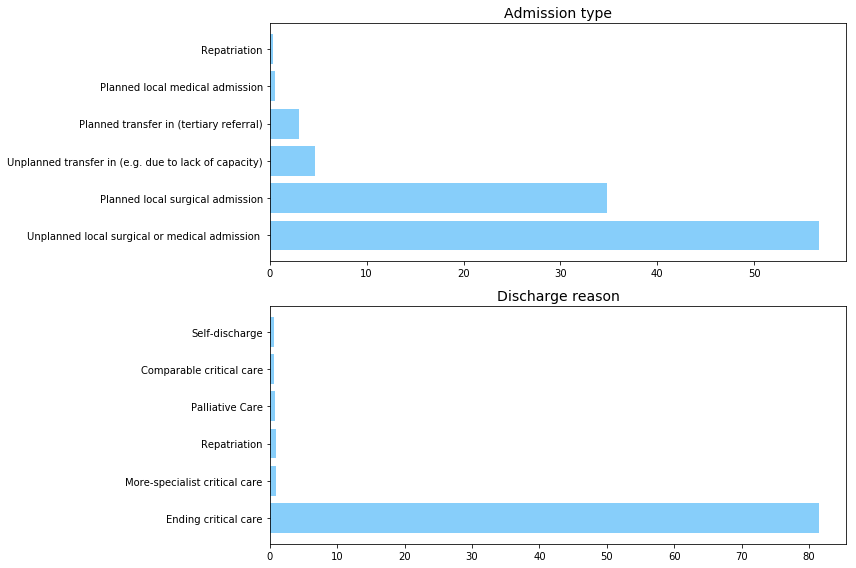

In [26]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 8))#, subplot_kw=dict(aspect="equal"))

ax[0].barh(np.arange(len(admission_type_groups)), admission_type_groups['percentage'], color='lightskyblue', tick_label=admission_type_groups['type'])
ax[0].set_title("Admission type", fontsize=14)

ax[1].barh(np.arange(len(discharge_reason_groups)), discharge_reason_groups['percentage'], color='lightskyblue', tick_label=discharge_reason_groups['type'])
ax[1].set_title("Discharge reason", fontsize=14)

plt.tight_layout()
plt.savefig('admisson_types_discharge_reasons.png')

In [27]:
rfd = icnarc_data[~icnarc_data['Datetime when fully ready to discharge'].isna()]['Datetime when fully ready to discharge']
ddt = icnarc_data[~icnarc_data['Datetime of discharge from your unit'].isna()]['Datetime of discharge from your unit']

delay = icnarc_data[~icnarc_data['Datetime when fully ready to discharge'].isna()]
delay = delay['Datetime of discharge from your unit'] - delay['Datetime when fully ready to discharge']

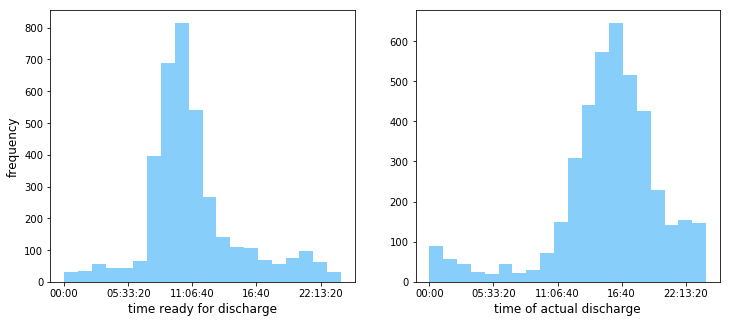

In [28]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
p1 = plt.hist(rfd.apply(lambda x: x.time()).values, bins=20, color='lightskyblue')
plt.xlabel("time ready for discharge", fontsize=12)
plt.ylabel("frequency", fontsize=12)

plt.subplot(1,2,2)
p2 = plt.hist(ddt.apply(lambda x: x.time()).values, bins=20, color='lightskyblue')
plt.xlabel("time of actual discharge", fontsize=12);

plt.savefig('discharge_time_histograms.png')

#### Now plot length of stay and discharge delay...

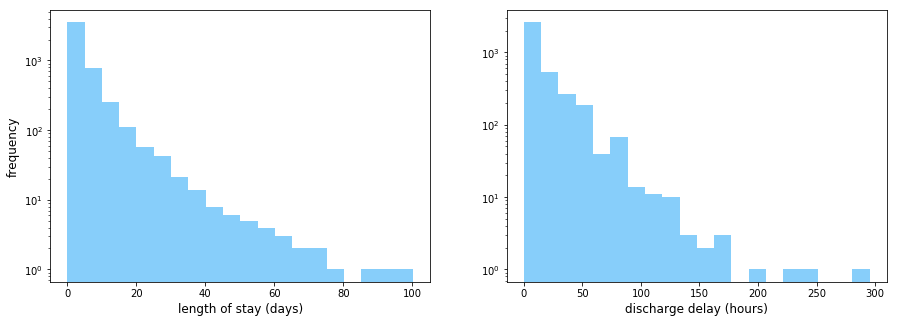

In [29]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(icnarc_data['icnarc_los']/(60*24), bins=20, color='lightskyblue');
plt.yscale('log')
plt.xlabel('length of stay (days)', fontsize=12)
plt.ylabel('frequency', fontsize=12);

plt.subplot(1,2,2)
plt.hist(delay.apply(lambda x : x.total_seconds()/(60.0*60)), bins=20, color='lightskyblue');
plt.yscale('log')
plt.xlabel('discharge delay (hours)', fontsize=12);

plt.savefig('stay_length_histograms.png')

<a id='section2'></a>

### 2. Demonstration analysis.

#### We now load and process physiological data from Philips. These data contain a selection of variables most commonly used in our research and audits. 

This data comes from two tables in ICCA:
* PtAssessment - containing flowsheet data, often recorded at high frequnecy (~1record/hr)
* PtLabResult - containing laboratory results data (and similar), usually recorded at lower frequency (~1record/day) 

For simplicity we combine these data into a single table, 'chartevents'. 

#### Here we combine and call it chartevents, but in the research database it remains two (or more tables):

In [30]:
chartevents = clean_philips_encounterids('../ptassess_physiological_data.rpt', 
                                  '../Philips encounterId Issue List (New).xlsx',
                                  verbose=VERBOSE, date_columns=['chartTime', 'storeTime'])

In [31]:
chartevents = chartevents.append(clean_philips_encounterids('../labresults_physiological_data.rpt', 
                                  '../Philips encounterId Issue List (New).xlsx',
                                  verbose=VERBOSE, date_columns=['chartTime', 'storeTime']))

#### Get only encounters that appear in our icustays table: 

In [ ]:
chartevents = chartevents.merge(icnarc_data[['encounterId']],how='right', on='encounterId')

#### Extract numbers from variables that use valueString rather than valueNumber:

Note: processing this large table is slow. We save it to disk after each stage of processing so it doesn't need to be repeated.

In [ ]:
chartevents['value'] = [row['valueString'] if row['attributeId'] in [16240,6847,6849,6851,8590, 34870, 34873, 8584, 3566, 25545] else row ['valueNumber'] for i,row in chartevents.iterrows()]

#### Get key that defines each variable/intervention/attribute:

In [39]:
interventions = pd.read_excel('interventions_and_attributes.xlsx', sheet_name='key')

In [ ]:
chartevents = pd.merge(chartevents, interventions, how='left', left_on=['interventionId', 'attributeId'], right_on=['interventionId', 'attributeId'])

In [ ]:
#chartevents.to_csv('cohort_chartevents.csv')
chartevents = pd.read_csv('cohort_chartevents.csv', parse_dates=[2,3])

#### How many icustays have a recording of each variable:

In [33]:
record_completeness = chartevents.groupby('Variable').agg({'encounterId':pd.Series.nunique}).sort_values('encounterId', ascending=False)
record_completeness = record_completeness.rename(columns={'encounterId':'completeness'})
record_completeness['completeness'] /= float(len(chartevents.encounterId.unique()))

In [34]:
record_completeness

,completeness
Variable,
Serum sodium,0.998965
Serum potassium,0.998965
Heart Rate,0.996895
Respiratory Rate,0.996481
SpO2,0.995239
GCS,0.992962
GCS Eyes,0.992962
GCS Motor,0.992962
GCS Verbal,0.992962


In [35]:
counts = chartevents.groupby(['encounterId', 'Variable']).agg({'encounterId':['count'], 'chartTime':['min', 'max']})
counts.columns = list(map('_'.join, counts.columns.values))
counts = counts.reset_index()

In [36]:
counts = counts.merge(icnarc_data[['encounterId','icnarc_los']], on='encounterId', how='inner')
counts['freq'] = [row['encounterId_count']/(row['icnarc_los']/(60.0)) for i,row in counts.iterrows()]

In [37]:
freqs = counts.groupby('Variable').agg({'freq':['mean', 'std']})
freqs.columns = list(map('_'.join, freqs.columns.values))
freqs.sort_values('freq_mean', ascending=False)

,freq_mean,freq_std
Variable,,
Respiratory Rate,1.310394,0.923121
FiO2,0.922432,0.788986
Heart Rate,0.835824,0.311151
SpO2,0.809720,0.309111
Arterial BP Mean,0.699568,0.356515
Arterial BP Diastolic,0.698276,0.355979
Arterial BP Systolic,0.698062,0.356200
Airway,0.671725,0.297497
Access (Arterial) Pressure,0.661339,1.218776


#### What do the distributions of variable values look like?

First we remove variables we don't want to calculate distributions for:

In [40]:
variables = [i for i in interventions['Variable'].unique() if i not in ['Airway', 'GCS Motor', 'GCS Verbal', 'GCS Eyes', 'Pain Scale (VAS) (on movement)', 'Pain Scale (VAS)', 'Access (Arterial) Pressure']]
len(variables)

26

In [41]:
chartevents_nona = chartevents.dropna(subset=['value'])
#sum(~chartevents[chartevents['Variable']=='Pain Scale (VAS)']['value'].isna()) ## all Pain scale values recorded as ValueString

In [42]:
def plot_variable_histogram_grid(var_names, var_list=[]):
    
    plt.figure(figsize=(15,15))
    for i,j in enumerate(var_list):
        print var_names[j]
        
        ax = plt.subplot(3,3,i+1)
        vvals = chartevents[chartevents['Variable']==var_names[j]]['value']
        
        if len(vvals)>0:
            vvals = pd.to_numeric(vvals, errors='coerce')
            plt.hist(vvals.dropna().values, bins=20, color='lightskyblue');
            ax.set_xlabel(var_names[j])
            if i in [0,3,6]:
                ax.set_ylabel('frequency')
        else:
            print var + " not in chartevents."

GCS
FiO2
Heart Rate
Haemoglobin
Respiratory Rate
SpO2
Non-Invasive BP Mean
Non-Invasive BP Systolic
Non-Invasive BP Diastolic
Arterial BP Mean
Arterial BP Systolic
Arterial BP Diastolic
Peripheral Temperature
Central Temperature
Serum pH
Serum sodium
Serum potassium
Serum ionised calcium
Serum bicarbonate
Serum urea
Serum creatinine
PEEP
pO2
pCO2 
Bilirubin
Platelets


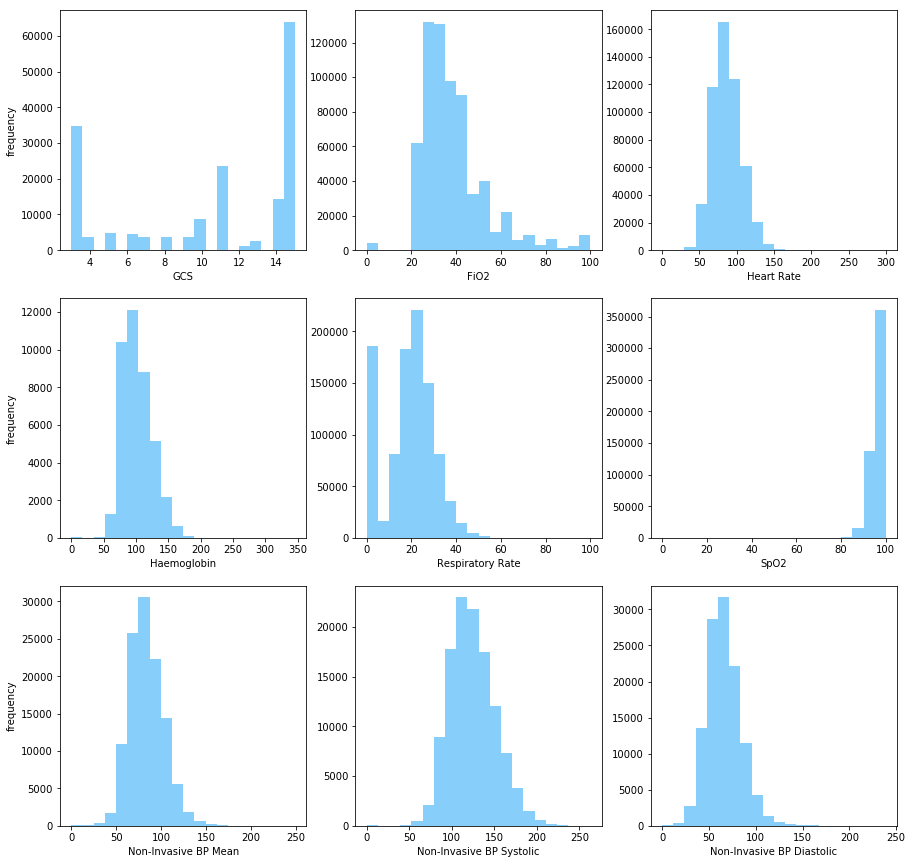

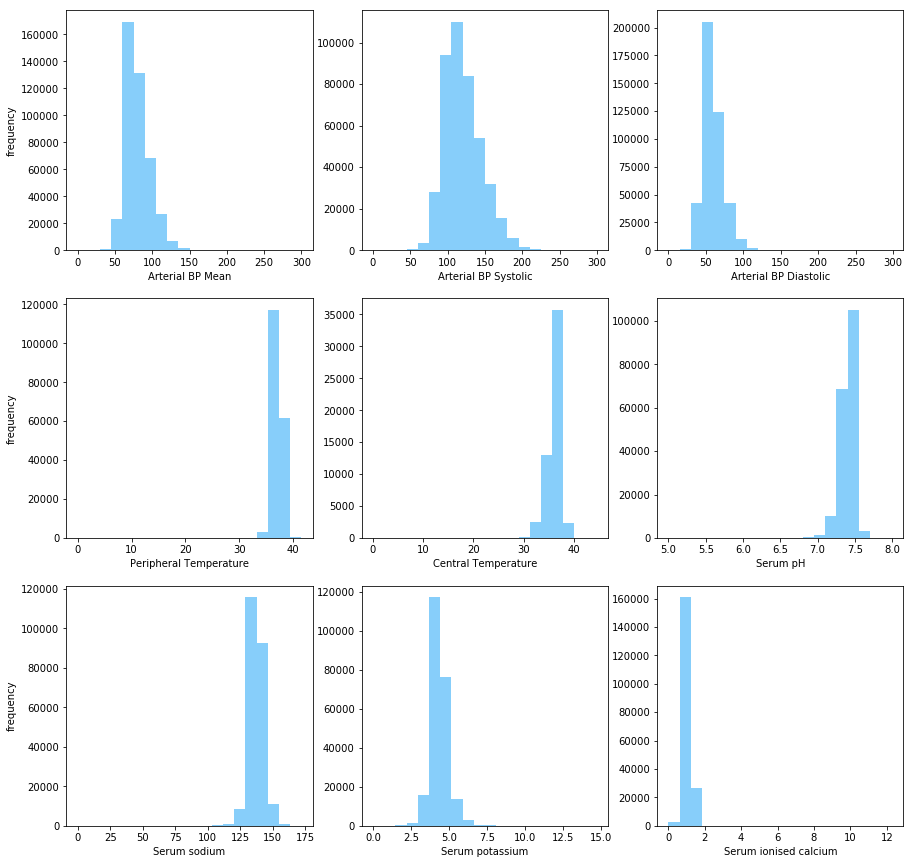

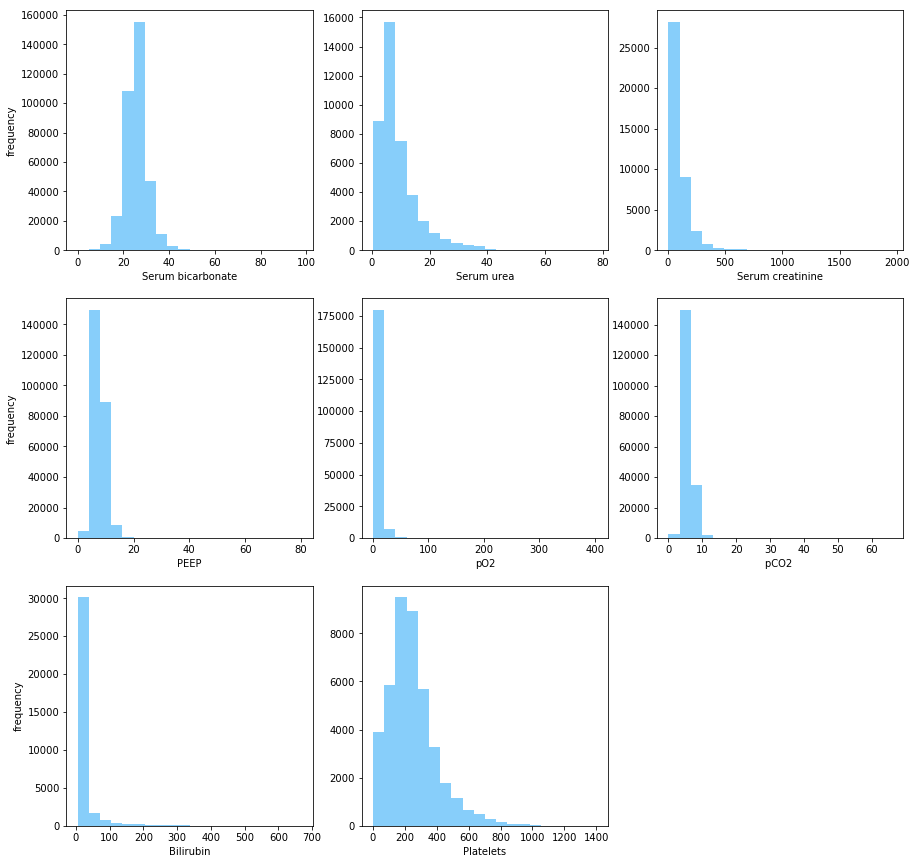

In [43]:
plot_variable_histogram_grid(variables, np.arange(9))
plt.savefig('variable_hists1.png')

plot_variable_histogram_grid(variables, np.arange(9)+9)
plt.savefig('variable_hists2.png')

plot_variable_histogram_grid(variables, np.arange(8)+18)
plt.savefig('variable_hists3.png')

#### What are the average values of each variable?

In [44]:
for i,var in enumerate(variables):
    vvals = chartevents[chartevents['Variable']==var]['value'] 
    
    mean = np.mean(pd.to_numeric(vvals, errors='coerce'))
    std = np.std(pd.to_numeric(vvals, errors='coerce'))
    
    print var + ' : %.3f (%.3f)' %(mean,std) 

GCS : 10.472 (4.753)
FiO2 : 36.510 (14.576)
Heart Rate : 85.878 (19.061)
Haemoglobin : 101.869 (22.866)
Respiratory Rate : 18.430 (11.187)
SpO2 : 95.705 (3.567)
Non-Invasive BP Mean : 83.908 (19.369)
Non-Invasive BP Systolic : 124.320 (26.622)
Non-Invasive BP Diastolic : 65.870 (18.173)
Arterial BP Mean : 80.043 (18.327)
Arterial BP Systolic : 119.991 (24.731)
Arterial BP Diastolic : 59.305 (14.074)
Peripheral Temperature : 37.060 (0.961)
Central Temperature : 36.100 (1.801)
Serum pH : 7.396 (0.093)
Serum sodium : 137.267 (5.571)
Serum potassium : 4.379 (0.599)
Serum ionised calcium : 1.127 (0.154)
Serum bicarbonate : 25.654 (4.837)
Serum urea : 9.133 (6.912)
Serum creatinine : 105.553 (89.350)
PEEP : 8.018 (2.747)
pO2 : 10.873 (5.714)
pCO2  : 5.622 (1.414)
Bilirubin : 23.915 (48.743)
Platelets : 246.143 (151.254)
